<a href="https://colab.research.google.com/github/aom12345/Architecting-LLMs-Om/blob/main/week3_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import random
%matplotlib inline

In [42]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2026-01-03 13:38:00--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2026-01-03 13:38:00 (7.46 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [43]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [44]:
len(words)

32033

In [45]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [46]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [47]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

# E01 : Better model by adjusting hyper parameters and design

In [48]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
emb_dims = 15
first_dims = 165
#second_dims = 27

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [49]:
# ------------ now made respectable :) ---------------

In [50]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, emb_dims), generator=g)
W1 = torch.randn((emb_dims*block_size, first_dims), generator=g)
b1 = torch.randn(first_dims, generator=g)
W2 = torch.randn((first_dims, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [51]:
sum(p.nelement() for p in parameters) # number of parameters in total

12477

In [52]:
for p in parameters:
  p.requires_grad = True

In [53]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [54]:
lri = []
lossi = []
stepi = []

In [55]:
batch_size=32

In [56]:
lossprev = torch.tensor([0])
loss1 = torch.tensor([0])
lr = 0.1
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, block_size*emb_dims) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  if i%15000 ==0:
    emb1 = C[Xtr] # (32, 3, 2)
    h1 = torch.tanh(emb1.view(-1, emb_dims*block_size) @ W1 + b1) # (32, 100)
    logits1 = h1 @ W2 + b2 # (32, 27)
    loss1 = F.cross_entropy(logits1, Ytr)
    if loss1.item()>(lossprev.item()) and lossprev.item()!=0:
      lr = 0.01
    else:
      lr=0.1
    lossprev =loss1
  # update
  #lr = lrs[i]

  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

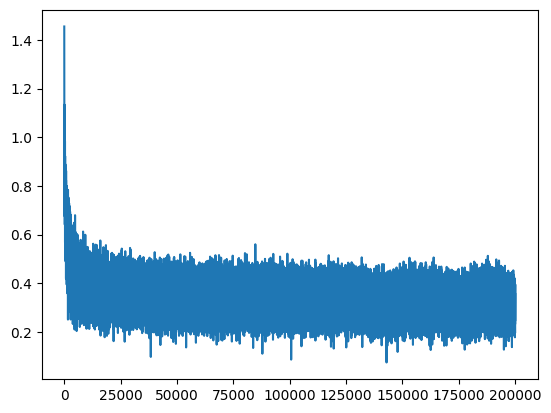

In [57]:
plt.plot(stepi, lossi)

In [58]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_dims*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0809, grad_fn=<NllLossBackward0>)

In [59]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,emb_dims*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1406, grad_fn=<NllLossBackward0>)

# E02 : Starting with all uniform weights

In [60]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
emb_dims = 15
first_dims = 165
#second_dims = 27

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [61]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.ones((27, emb_dims))
W1 = torch.ones((emb_dims*block_size, first_dims))
b1 = torch.ones(first_dims)
W2 = torch.ones((first_dims, 27))
b2 = torch.ones(27)
parameters = [C, W1, b1, W2, b2]

In [62]:
sum(p.nelement() for p in parameters) # number of parameters in total

12477

In [63]:
for p in parameters:
  p.requires_grad = True

In [64]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [65]:
lri = []
lossi = []
stepi = []

In [66]:
batch_size=32

In [67]:
lossprev = torch.tensor([0])
loss1 = torch.tensor([0])
lr = 0.01
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, block_size*emb_dims) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  if i%15000 ==0:
    emb1 = C[Xtr] # (32, 3, 2)
    h1 = torch.tanh(emb1.view(-1, emb_dims*block_size) @ W1 + b1) # (32, 100)
    logits1 = h1 @ W2 + b2 # (32, 27)
    loss1 = F.cross_entropy(logits1, Ytr)
    if loss1.item()>(lossprev.item()) and lossprev.item()!=0:
      lr = 0.001
    else:
      lr=0.005
    lossprev =loss1
  # update
  #lr = lrs[i]

  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

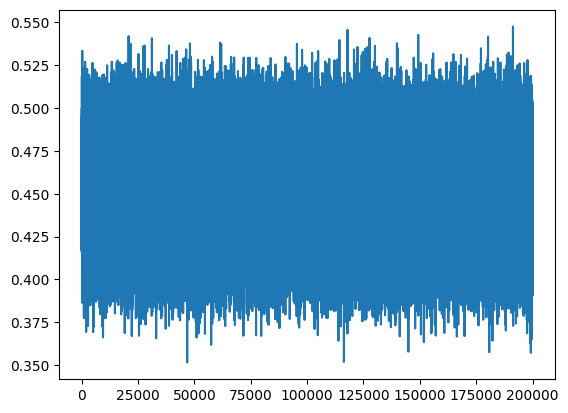

In [68]:
plt.plot(stepi, lossi)

In [69]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_dims*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.8250, grad_fn=<NllLossBackward0>)

In [70]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,emb_dims*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.8196, grad_fn=<NllLossBackward0>)

In [71]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

narmahxaae.
hlrihkimrs.
reaty.
hnaassnejr.
hnenfamesahc.
iaeei.
.
e.
maia.
ceaiiv.
e.
lein.
h.
.
m.
.
oin.
eeijn.
s.
lilea.


# E02 : Better probs with a little entropy

In [72]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
emb_dims = 15
first_dims = 165
#second_dims = 27

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [73]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, emb_dims), generator=g)
W1 = torch.randn((emb_dims*block_size, first_dims), generator=g)*0.1
b1 = torch.randn(first_dims, generator=g)*0.01
W2 = torch.randn((first_dims, 27), generator=g)*0.01
b2 = torch.zeros(27)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [74]:
sum(p.nelement() for p in parameters) # number of parameters in total

12477

In [75]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [76]:
lri = []
lossi = []
stepi = []

In [77]:
batch_size=32

In [78]:
lossprev = torch.tensor([0])
loss1 = torch.tensor([0])
lr = 0.10
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, block_size*emb_dims) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  if i>100000:
    lr=0.01
  # update
  #lr = lrs[i]

  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())


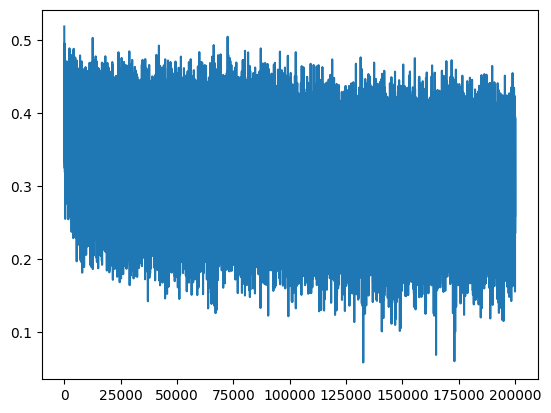

In [79]:
plt.plot(stepi, lossi)

In [80]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_dims*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0338, grad_fn=<NllLossBackward0>)

In [81]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,emb_dims*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1149, grad_fn=<NllLossBackward0>)

# E03 : Implementing some concepts from the paper

In [82]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
emb_dims = 15
first_dims = 165
#second_dims = 27

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [83]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, emb_dims), generator=g)
W1 = torch.randn((emb_dims*block_size, first_dims), generator=g)/((emb_dims * block_size)**0.5)
b1 = torch.randn(first_dims, generator=g)*0.01
W2 = torch.randn((first_dims, 27), generator=g)*0.01
b2 = torch.zeros(27)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [84]:
sum(p.nelement() for p in parameters) # number of parameters in total

12477

In [85]:
lri = []
lossi = []
stepi = []

In [86]:
batch_size=32

In [87]:
lossprev = torch.tensor([0])
loss1 = torch.tensor([0])
lr = 0.10
r = 200000
for i in range(r):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, block_size*emb_dims) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2
  #logits = b2 + (h+(emb.view(-1, block_size*emb_dims) @ W1 + b1))@W2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  lr = (0.1/r)*(r**2 - i**2)**0.5
  # update
  #lr = lrs[i]

  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())


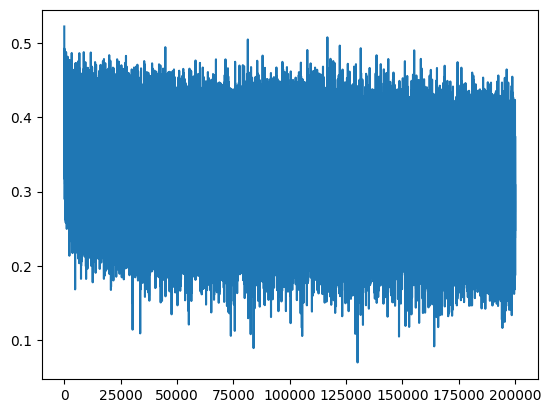

In [88]:
plt.plot(stepi, lossi)

In [89]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_dims*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0142, grad_fn=<NllLossBackward0>)

In [90]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,emb_dims*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1002, grad_fn=<NllLossBackward0>)

Just by implementing an eleiptical function for gradient we get a better loss

In [91]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
emb_dims = 15
first_dims = 165
#second_dims = 27

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])


In [92]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, emb_dims), generator=g)
W1 = torch.randn((emb_dims*block_size, first_dims), generator=g)/((emb_dims * block_size)**0.5) # I am not using 5/3 because of 1 non linear layer
b1 = torch.randn(first_dims, generator=g)*0.0
W2 = torch.randn((first_dims, 27), generator=g)*0.01
b2 = torch.zeros(27)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [93]:
sum(p.nelement() for p in parameters) # number of parameters in total

12477

In [94]:
lri = []
lossi = []
stepi = []

In [95]:
batch_size=32

In [96]:
lossprev = torch.tensor([0])
loss1 = torch.tensor([0])
lr = 0.10
r = 200000
for i in range(r):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, block_size*emb_dims) @ W1 + b1) # (32, 200)
  #logits = h @ W2 + b2
  logits = b2 + (h+(emb.view(-1, block_size*emb_dims) @ W1 + b1)*0.015)@W2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  lr = (0.1/r)*(r**2 - i**2)**0.5
  # update
  #lr = lrs[i]

  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())


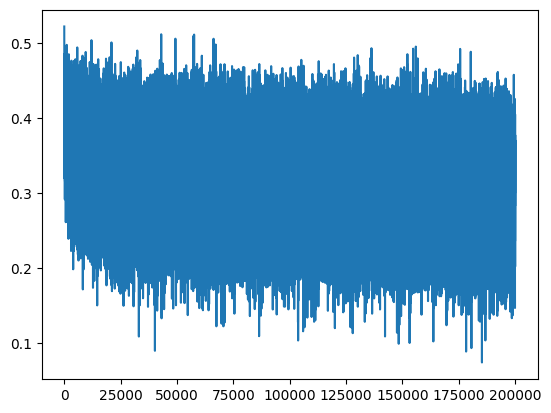

In [97]:
plt.plot(stepi, lossi)

In [98]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_dims*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0165, grad_fn=<NllLossBackward0>)

In [99]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,emb_dims*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1030, grad_fn=<NllLossBackward0>)

By adding a direct linear connection along with the nonlinearity we get a better loss also we cannot scale the linearity factor by using powers because there are negetive nubers also there hence we need to multiply it by a small number

# Part 2 E01 : if all weights were zero

In [100]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
emb_dims = 15
first_dims = 165
#second_dims = 27

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])


In [101]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, emb_dims), generator=g)*0
W1 = torch.randn((emb_dims*block_size, first_dims), generator=g)*0 # I am not using 5/3 because of 1 non linear layer
b1 = torch.randn(first_dims, generator=g)*0.0
W2 = torch.randn((first_dims, 27), generator=g)*0.0
b2 = torch.zeros(27)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [102]:
sum(p.nelement() for p in parameters) # number of parameters in total

12477

In [103]:
lri = []
lossi = []
stepi = []

In [104]:
batch_size=32

In [105]:
r = 200000
for i in range(r):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, block_size*emb_dims) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2
  #logits = b2 + (h+(emb.view(-1, block_size*emb_dims) @ W1 + b1)*0.015)@W2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  lr = (0.1/r)*(r**2 - i**2)**0.5
  # update
  #lr = lrs[i]

  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())


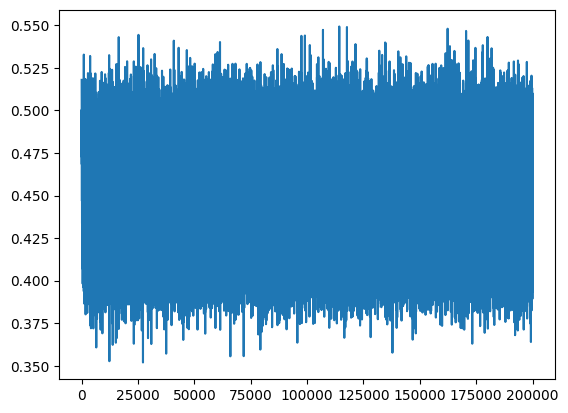

In [106]:
plt.plot(stepi, lossi)

In [107]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_dims*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.8236, grad_fn=<NllLossBackward0>)

In [108]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,emb_dims*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.8202, grad_fn=<NllLossBackward0>)

In [109]:
# d logits / d W2 = h which is initially 0 (tanh(0) = 0) and stays zero
# d logits / d b2 = 1
# d logits / d h = W2 which is initially 0 and stays zero
# so only the bias changes by a small amount hence the training is very bad

# E02 : # layered MLP with both folded and not folded Batchnorm

In [110]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182484, 3]) torch.Size([182484])
torch.Size([22869, 3]) torch.Size([22869])
torch.Size([22793, 3]) torch.Size([22793])


In [111]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2

W2 = torch.randn((n_hidden, n_hidden),          generator=g) * 0.01

W3 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b3 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
bngain2 = torch.ones((1, n_hidden))
bnbias2 = torch.zeros((1, n_hidden))
bnmean_running2 = torch.zeros((1, n_hidden))
bnstd_running2 = torch.ones((1, n_hidden))
parameters = [C, W1, W2,W3, b3, bngain, bnbias,bngain2, bnbias2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

52497


In [112]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden la
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  h = torch.tanh(hpreact)

# hidden layer2
  hpreact = h @ W2
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani2 = hpreact.mean(0, keepdim=True)
  bnstdi2 = hpreact.std(0, keepdim=True)
  hpreact = bngain2 * (hpreact - bnmeani2) / bnstdi2 + bnbias2
  with torch.no_grad():
    bnmean_running2 = 0.999 * bnmean_running2 + 0.001 * bnmeani2
    bnstd_running2 = 0.999 * bnstd_running2 + 0.001 * bnstdi2
  # -------------------------------------------------------------
  h = torch.tanh(hpreact)
  logits = h @ W3 + b3
  loss = F.cross_entropy(logits, Yb)

  for p in parameters:
    p.grad = None
  loss.backward()

  lr = (0.1/max_steps)*(max_steps**2 - i**2)**0.5  # eleptical function for gradient
  for p in parameters:
    p.data += -lr * p.grad


  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3019
  10000/ 200000: 2.4992
  20000/ 200000: 2.5808
  30000/ 200000: 2.3863
  40000/ 200000: 2.2074
  50000/ 200000: 2.2675
  60000/ 200000: 2.1705
  70000/ 200000: 2.2385
  80000/ 200000: 2.0826
  90000/ 200000: 2.1410
 100000/ 200000: 2.4000
 110000/ 200000: 2.2304
 120000/ 200000: 3.0021
 130000/ 200000: 2.1894
 140000/ 200000: 1.8076
 150000/ 200000: 1.9032
 160000/ 200000: 1.9774
 170000/ 200000: 1.9359
 180000/ 200000: 1.8652
 190000/ 200000: 1.8556


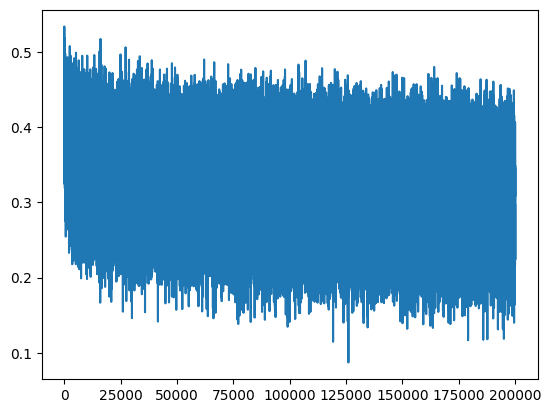

In [113]:
plt.plot(lossi)

In [114]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  hpreact = h @ W2
  hpreact = bngain2 * (hpreact - bnmean_running2) / bnstd_running2 + bnbias2
  h = torch.tanh(hpreact)
  logits = h @ W3 + b3
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9999157190322876
val 2.071953058242798


In [115]:
W11 = W1*bngain/bnstd_running
B11 = (bnbias- bnmean_running*bngain/bnstd_running)
W21 = W2*bngain2/bnstd_running2
B21 = (bnbias2- bnmean_running2*bngain2/bnstd_running2)
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)

  #Folded
  hpreact = embcat@W11+ B11

  h = torch.tanh(hpreact)

  hpreact = h@W21+ B21

  h = torch.tanh(hpreact)
  logits = h @ W3 + b3
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9999157190322876
val 2.071953058242798
